In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/unzipped_folder/visual_prompting/evaluate')

In [ ]:
!pip install timm
!pip install pytorch_lightning
!pip install einops
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=24dc6bc5c61100e4575a27acfb4de02d57aba188725c6e3735ff5c3a58f14ed6
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import os
import random
import torch
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import torchvision
from mae_utils import *
import PIL
import requests
from io import BytesIO
from PIL import Image

## Load model

In [ ]:
ckpt = '/content/drive/My Drive/unzipped_folder/visual_prompting/checkpoint-3400.pth'
model = prepare_model(ckpt, arch='mae_vit_large_patch16')

model.eval()
model = model.to('cuda')

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Missing VQGAN keys: []
<All keys matched successfully>


## Setup utils and preprocessing

In [ ]:

# A generalized imshow helper function which supports displaying (CxHxW) tensor
def generalized_imshow(arr):
    if isinstance(arr, torch.Tensor) and arr.shape[0] == 3:
        arr = arr.permute(1, 2, 0)
    plt.imshow(arr)
    plt.show()

def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

def create_grid_from_images(support_img, support_mask, query_img, query_mask, padding=1):
    canvas = torch.zeros((support_img.shape[0], 2 * support_img.shape[1] + 2 * padding,
                         2 * support_img.shape[2] + 2 * padding))
    canvas[:, :support_img.shape[1], :support_img.shape[2]] = support_img
    canvas[:, -query_img.shape[1]:, :query_img.shape[2]] = query_img
    canvas[:, :support_img.shape[1], -support_img.shape[2]:] = support_mask
    canvas[:, -query_img.shape[1]:, -support_img.shape[2]:] = query_mask

    return canvas

import torchvision
padding = 1
image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((224 // 2 - padding, 224 // 2 - padding)),
     torchvision.transforms.ToTensor()])

single_image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((224, 224)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# Different functions to construct visual prompts

In [ ]:
import requests
from io import BytesIO
from PIL import Image


def url_to_pil(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

"""
def run_model(source, target, new_source):
    source = url_to_pil(source).convert('RGB')
    target = url_to_pil(target).convert('RGB')
    new_source =  url_to_pil(new_source).convert('RGB')

    source = image_transform(source)
    target = image_transform(target)
    new_source = image_transform(new_source)
    grid = create_grid_from_images(source, target, new_source, new_source)
    grid = (grid - imagenet_mean[:,None,None]) / imagenet_std[:, None,None]
    grid = grid[np.newaxis, :, :, :]
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)          # CHANGE DPI
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))
"""

def run_model(source, target, new_source, id):  # MODIFIED
    source = url_to_pil(source).convert('RGB')
    target = url_to_pil(target).convert('RGB')
    new_source =  url_to_pil(new_source).convert('RGB')

    source = image_transform(source)
    target = image_transform(target)
    new_source = image_transform(new_source)
    grid = create_grid_from_images(source, target, new_source, new_source)
    grid = (grid - imagenet_mean[:,None,None]) / imagenet_std[:, None,None]
    grid = grid[np.newaxis, :, :, :]
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=500)          # CHANGE DPI
    #return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))
    generated_image = PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))
    output_folder = '/content/drive/My Drive/generated'  # OUTPUT FOLDER
    output_filename = f'{id}.png'
    output_path = os.path.join(output_folder, output_filename)
    generated_image.save(output_path)
    return output_path

# load image, occlude bottom right part and predict the completion
def run_model_single_img(img):
    img = url_to_pil(img).convert('RGB')
    img = single_image_transform(img)
    grid = img[np.newaxis, :, :, :]


    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))

def run_model_with_variable_placements(source, target, new_source):
    source_p = url_to_pil(source).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(source_p.resize((256,256)), (0, 0, 256, 256))
    source = im

    target_p = url_to_pil(target).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(target_p.resize((256, 256)), (128, 128, 384, 384))
    target = im

    new_source_p =  url_to_pil(new_source).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(new_source_p.resize((256,256)), (0, 0, 256, 256))
    new_source = im

    source = image_transform(source)
    target = image_transform(target)
    new_source = image_transform(new_source)
    grid = create_grid_from_images(source, target, new_source, new_source)
    grid = (grid - imagenet_mean[:,None,None]) / imagenet_std[:, None,None]
    grid = grid[np.newaxis, :, :, :]
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))


# Run model on internet images, manully construct the visual prompt

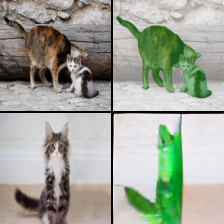

In [ ]:
source = "https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image001-300.jpg"
target ="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image003-300.png"
new_source = "https://static.scientificamerican.com/sciam/cache/file/1E3A3E62-B3CA-434A-8C3B3ED0C982FB69_source.jpg?w=590&h=800&C8DB8C57-989B-4118-AE27EF1191E878A5"
run_model(source, target, new_source)

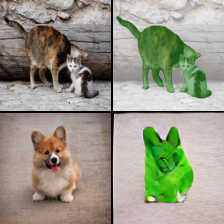

In [ ]:
source = "https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image001-300.jpg"
target ="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image003-300.png"
new_source = "https://www.wallpaperflare.com/static/307/786/534/welsh-corgi-puppy-dog-cute-wallpaper.jpg"
run_model(source, target, new_source)

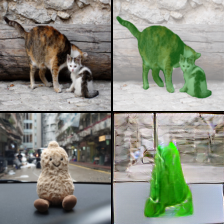

In [ ]:
# peanut
source = "https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image001-300.jpg"
target ="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image003-300.png"
new_source = "https://i.ibb.co/Cm5QmwN/IMG-1912.jpg"
run_model(source, target, new_source)

In [ ]:
source = "https://i.ibb.co/Jc144hF/IMG-1927.jpg"
target = "https://i.ibb.co/n8Vp1hY/IMG-1928.jpg"
new_source = "https://i.ibb.co/xfzVpfB/IMG-1931.jpg"
run_model(source, target, new_source, 2)

'/content/drive/My Drive/generated/2.png'

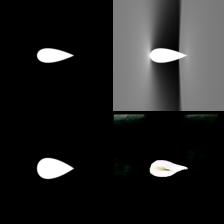

In [ ]:
source = "https://i.ibb.co/4TQvyYH/1.png"
target = "https://i.ibb.co/Y3pnbdP/2.png"
new_source = "https://i.ibb.co/KyBS1pX/3.png"
run_model(source, target, new_source)  # 不太行

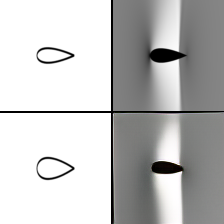

In [ ]:
source = "https://i.ibb.co/cC6Zc1B/contour.png"
target = "https://i.ibb.co/54gMjmG/5.png"
new_source = "https://i.ibb.co/P9NRLMm/contour-1.png"
run_model(source, target, new_source)   # 还可以

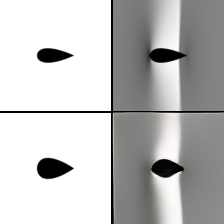

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/54gMjmG/5.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)   # 还可以

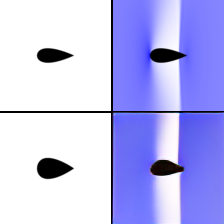

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/9HsPk5k/9.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)   # ok

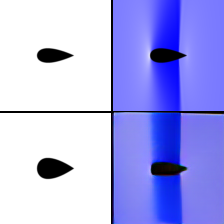

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/Lg79cct/10.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)   # OK

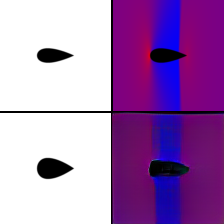

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/tcZXbpx/11.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)

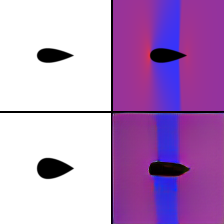

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/XLPKg9f/13.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)

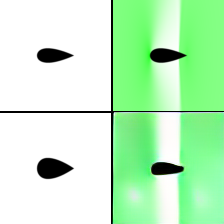

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/0tN7N3N/14.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)  # 有两个白圈

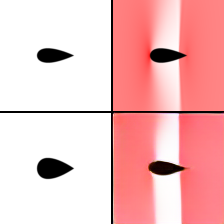

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/h74bVt7/15.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)  # OK

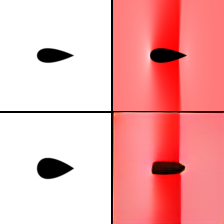

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/QJC2Q80/16.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)  # weird airfoil shape

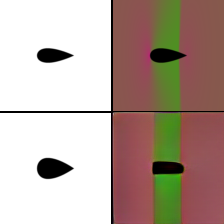

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/fXQKjgq/17.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source)  # bad

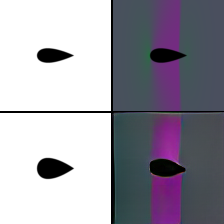

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/VjdRXQV/18.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source) # 一般

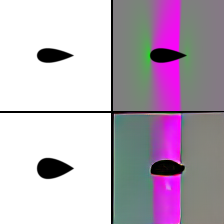

In [ ]:
source = "https://i.ibb.co/44Ggqzn/4.png"
target = "https://i.ibb.co/QPC17Ww/19.png"
new_source = "https://i.ibb.co/nwy1HMH/6.png"
run_model(source, target, new_source) # no

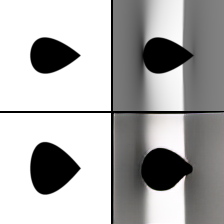

In [ ]:
source = "https://i.ibb.co/ZLBW54d/a.png"
target = "https://i.ibb.co/SV7QCVT/b.png"
new_source = "https://i.ibb.co/N1BBwfk/c.png"
run_model(source, target, new_source) # size

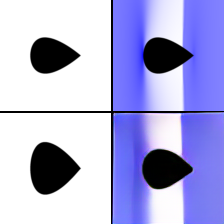

In [ ]:
source = "https://i.ibb.co/ZLBW54d/a.png"
target = "https://i.ibb.co/pZhYrL2/d.png"
new_source = "https://i.ibb.co/N1BBwfk/c.png"
run_model(source, target, new_source)

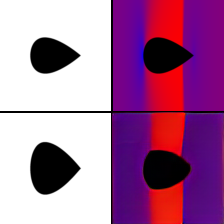

In [ ]:
source = "https://i.ibb.co/ZLBW54d/a.png"
target = "https://i.ibb.co/rt26ZQ0/e.png"
new_source = "https://i.ibb.co/N1BBwfk/c.png"
run_model(source, target, new_source)

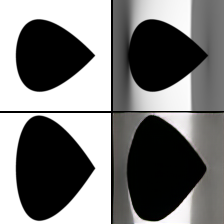

In [ ]:
source = "https://i.ibb.co/xKkcXYB/aa.png"
target = "https://i.ibb.co/6RwNh5q/bb.png"
new_source = "https://i.ibb.co/hYXDPJp/cc.png"
run_model(source, target, new_source)   # even bigger size

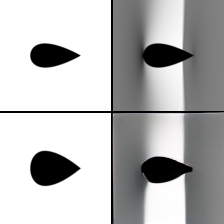

In [ ]:
# compare A and B
source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
target = "https://i.ibb.co/jT0jgZz/0013-actual-1000.png"
new_source = "https://i.ibb.co/6nJZX4K/0719-bw-1000.png"
run_model(source, target, new_source)

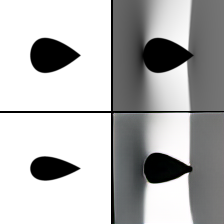

In [ ]:
# compare A and B
source = "https://i.ibb.co/6nJZX4K/0719-bw-1000.png"
target = "https://i.ibb.co/djWmnYn/0719-actual-1000.png"
new_source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
run_model(source, target, new_source)

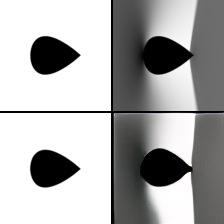

In [ ]:
# AGGREGATION
source = "https://i.ibb.co/ZWCX5LQ/0028-bw-1000.png"
target = "https://i.ibb.co/RPcsMV3/0028-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

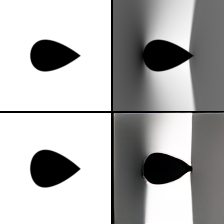

In [ ]:
source = "https://i.ibb.co/jWJW8jw/0423-bw-1000.png"
target = "https://i.ibb.co/GQ3dYdg/0423-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

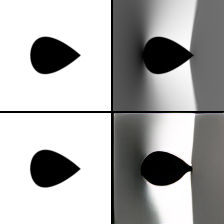

In [ ]:
source = "https://i.ibb.co/crwX0S9/0427-bw-1000.png"
target = "https://i.ibb.co/jy99zfz/0427-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

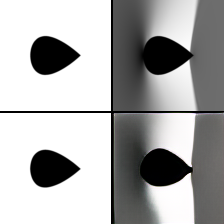

In [ ]:
source = "https://i.ibb.co/zQnSNZK/0528-bw-1000.png"
target = "https://i.ibb.co/sw1qQZG/0528-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

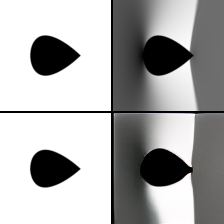

In [ ]:
source = "https://i.ibb.co/1d7hhH9/0729-bw-1000.png"
target = "https://i.ibb.co/412kZFN/0729-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

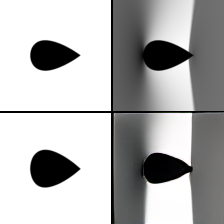

In [ ]:
source = "https://i.ibb.co/HBL7tDM/2022-bw-1000.png"
target = "https://i.ibb.co/f2VccK0/2022-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

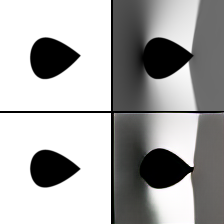

In [ ]:
source = "https://i.ibb.co/1Q2zLY2/2230-bw-1000.png"
target = "https://i.ibb.co/8DnwfYM/2230-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

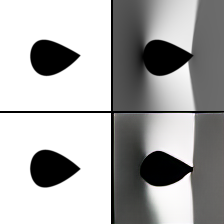

In [ ]:
source = "https://i.ibb.co/SXjsGKX/2526-bw-1000.png"
target = "https://i.ibb.co/CB0mwPG/2526-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

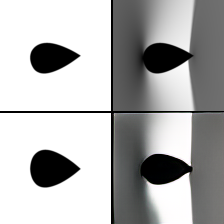

In [ ]:
source = "https://i.ibb.co/cw1SngC/23122-bw-1000.png"
target = "https://i.ibb.co/qWQqz3j/23122-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

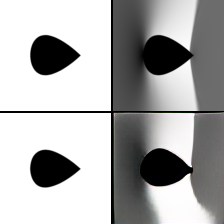

In [ ]:
source = "https://i.ibb.co/Mc9mxcH/26029-bw-1000.png"
target = "https://i.ibb.co/85XfRsQ/26029-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

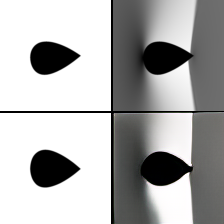

In [ ]:
source = "https://i.ibb.co/JdQGw69/24024-bw-10000.png"
target = "https://i.ibb.co/jRx1Lt6/24024-actual-1000.png"
new_source = "https://i.ibb.co/VBvb0TJ/0027-bw-1000.png"
run_model(source, target, new_source)

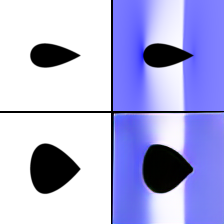

In [ ]:
# color
source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
target = "https://i.ibb.co/HhH36yk/0013-actual-1000-color.png"
new_source = "https://i.ibb.co/mNV3wSb/0027-bw-1000.png"
run_model(source, target, new_source)

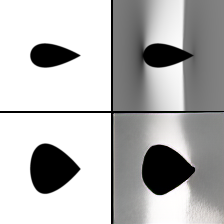

In [ ]:
# bw
source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
target = "https://i.ibb.co/jT0jgZz/0013-actual-1000.png"
new_source = "https://i.ibb.co/mNV3wSb/0027-bw-1000.png"
run_model(source, target, new_source)

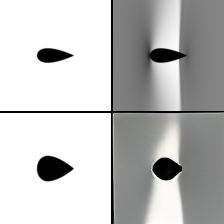

In [ ]:
# size small
source = "https://i.ibb.co/dJ32fn0/0013-bw-small.png"
target = "https://i.ibb.co/Fw0SVRK/0013-actual-small.png"
new_source = "https://i.ibb.co/VMMbvT4/0423-bw-small.png"
run_model(source, target, new_source)

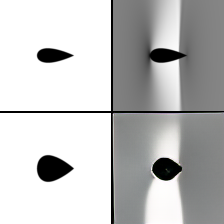

In [ ]:
# size small
source = "https://i.ibb.co/dJ32fn0/0013-bw-small.png"
target = "https://i.ibb.co/Fw0SVRK/0013-actual-small.png"
new_source = "https://i.ibb.co/d4Hrj3P/0124-bw-small.png"
run_model(source, target, new_source)

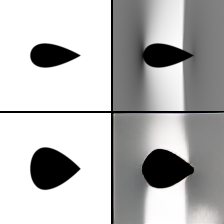

In [ ]:
# size middle
source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
target = "https://i.ibb.co/jT0jgZz/0013-actual-1000.png"
new_source = "https://i.ibb.co/HrNm4Zq/0423-bw-1000.png"
run_model(source, target, new_source)

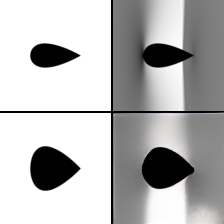

In [ ]:
# size middle
source = "https://i.ibb.co/6Bw79jd/0013-bw-1000.png"
target = "https://i.ibb.co/jT0jgZz/0013-actual-1000.png"
new_source = "https://i.ibb.co/cXBD5B6/0124-bw-middle.png"
run_model(source, target, new_source)

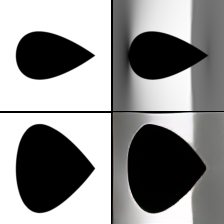

In [ ]:
# size large
source = "https://i.ibb.co/pLN7tMG/0013-bw-large.png"
target = "https://i.ibb.co/VQ9tWfz/0013-actual-large.png"
new_source = "https://i.ibb.co/WtJwDTn/0124-bw-large.png"
run_model(source, target, new_source)

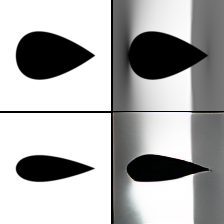

In [ ]:
# size large but flat
source = "https://i.ibb.co/pLN7tMG/0013-bw-large.png"
target = "https://i.ibb.co/VQ9tWfz/0013-actual-large.png"
new_source = "https://i.ibb.co/hVYvM1H/0124-bw-large-flat.png"
run_model(source, target, new_source)

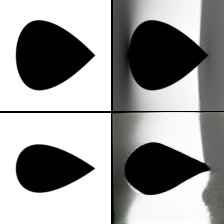

In [ ]:
source = "https://i.ibb.co/m8zhQGT/0719-bw-large.png"
target = "https://i.ibb.co/fqnPjCh/0719-actual-large.png"
new_source = "https://i.ibb.co/pLN7tMG/0013-bw-large.png"
run_model(source, target, new_source)

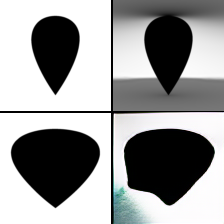

In [ ]:
# rotate
source = "https://i.ibb.co/BT3QJWb/0013-bw-large-rotate.png"
target = "https://i.ibb.co/Y3Wdf5Y/0013-actual-large-rotate.png"
new_source = "https://i.ibb.co/swhqyDv/0124-bw-large-rotate.png"
run_model(source, target, new_source)

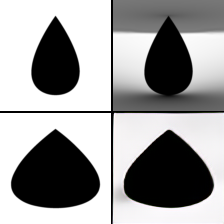

In [ ]:
# rotate
source = "https://i.ibb.co/HpdmdHN/0013-bw-large-rotate.png"
target = "https://i.ibb.co/pR2XJZZ/0013-actual-large-rotate.png"
new_source = "https://i.ibb.co/7p9jjVx/0124-bw-large-rotate.png"
run_model(source, target, new_source)

# Segmentation, colorization, style transfer examples

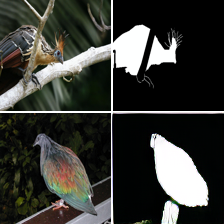

In [ ]:
run_model_single_img('https://yossigandelsman.github.io/visual_prompt/sup/assets/segmentation/0_31_BEIT.png')

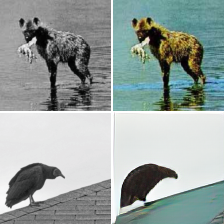

In [ ]:
run_model_single_img('https://yossigandelsman.github.io/visual_prompt/sup/assets/colorization/1177.png')

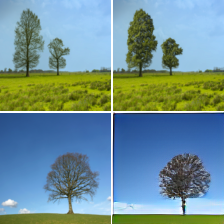

In [ ]:
run_model_single_img("https://yossigandelsman.github.io/visual_prompt/sup/assets/other/tree.png")

# Run model on internet images. Shifted apple, this is an example failure case of the model

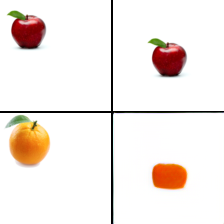

In [ ]:
import requests
from io import BytesIO
from PIL import Image
source = "https://st2.depositphotos.com/7036298/10694/i/450/depositphotos_106948346-stock-photo-ripe-red-apple-with-green.jpg"
target ="https://st2.depositphotos.com/7036298/10694/i/450/depositphotos_106948346-stock-photo-ripe-red-apple-with-green.jpg"
new_source = "https://www.quanta.org/orange/orange.jpg"
run_model_with_variable_placements(source, target, new_source)